In [66]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import Funciones as function

# El problema
En esta práctica trataremos un problema de clasificación en el que los datos que se proporcionan son unas 1000 palabras en lengua catalana y el mismo número de palabras en lengua inglesa. El objetivo es generar un documento en el que se detalle de forma clara y concisa el proceso seguido para la extracción de características y las decisiones tomadas en la construcción del modelo de clasificación basado en SVM.

## Los datos
#### Importamos los datos

*Para leer el dataset usaremos la función [**read_csv()**](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) de [**pandas**](https://pandas.pydata.org/)*

In [67]:
df = pd.read_csv("data.csv",sep="\s+")
df.head(5)

,0,catala,angles
0,1,com,as
1,3,seva,his
2,4,que,that
3,5,ell,he
4,6,era,was


#### Preparamos los datos
Debido a que tenemos el dataset separado en dos columnas en función de su idioma, lo primero que tenemos que hacer para empezar a trabajar con los datos es mover todas las palabras a una misma columna "palabra", y hemos creado una segunda columna "idioma" en la que hemos etiquetado cada una de las muestras con el idioma correspondiente, -1 para las palabras en catalán y 1 para las palabras en inglés.

*Usaremos la función [**rename()**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html) para cambiar el nombre de las columnas, la función [**concat()**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) nos permite concatenar verticalmente dos dataframe y por último [**reset_index()**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) nos permite reiniciar los índices, que al fusionar los dataframes no siguen un orden, y asi el dataframe queda ordenado*

In [68]:
df_catalan = pd.DataFrame(df['catala']) #Creamos un dataframe a partir del dataframe original para separar catalan
df_catalan['idioma'] = -1 #Establecemos un valor de -1 para todas las palabras en catalán
df_catalan.rename(columns={'catala': 'palabra'}, inplace=True) #Renombramos la columna de 'catala' a 'palabra'

df_ingles = pd.DataFrame(df['angles']) #Creamos un dataframe a partir del dataframe original para separar ingles
df_ingles['idioma'] = 1 #Establecemos un valor de 1 para todas las palabras en inglés
df_ingles.rename(columns={'angles': 'palabra'}, inplace=True) #Renombramos la columna de 'ingles' a 'palabra'

df_idiomas = pd.concat([df_catalan,df_ingles],axis=0) #Fusionamos df_catala y df_ingles en un solo dataframe
df_idiomas = df_idiomas.reset_index(drop=True) #Reiniciamos los índices para que tengan continuidad
df_idiomas.tail(5)

,palabra,idioma
1971,nose,1
1972,plural,1
1973,anger,1
1974,claim,1
1975,continent,1


Para mostrar los resultados finales crearemos un dataset que iremos rellenando con los datos de los diferentes modelos.

In [69]:
res_cat=[]
res_ing=[]
res_glo=[]

## PRIMERA ITERACIÓN
Para esta iteración nuestra intención es extraer algunas características genéricas de una palabra y realizar una primera prueba para observar los resultados. Las características serán las siguientes:
- **num_vocales**: Número total de vocales de una muestra.
- **num_cons**: Número total de consonantes de una muestra.
- **longitud**: Longitud de una muestra.
- **conjuntosVocales**: Número total de conjuntos de más de una vocal de una muestra.

In [70]:
df_idiomas1 = df_idiomas.copy() # Copiamos el dataset original para mantenerlo limpio

*Contamos el número de vocales haciendo uso de nuestra función **count_chars()** definida dentro de **Funciones.py**,esta función cuenta las veces que aparece alguno de los terminos de una secuencia en la palabra*

In [71]:
search_terms = 'aeiouáéíóúàèìòùäëïöüâêîôû' #Hay que contar todas las vocales incluyendo las vocales con acentos
df_idiomas1['num_vocales']=function.count_chars(df_idiomas1['palabra'],search_terms) # Usaremos nuestra propia función count_chars()
df_idiomas1.head(5)

,palabra,idioma,num_vocales
0,com,-1,1
1,seva,-1,2
2,que,-1,2
3,ell,-1,1
4,era,-1,2


*Contamos el número de consonantes, como una palabra está formada por vocales y consonantes y ya sabemos el número de vocales que tienen, entonces el número de consonantes es el número de letras de una palabra menos la cantidad de vocales.
A partir de aquí se usará bastante la función [**iloc[]**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html) que nos permitirá recorrer los dataframe y sus columnas, ya que nos permite acceder a una position de estos usando un índice*

In [72]:
num_cons=[]
for i in range(len(df_idiomas1)):
    num_cons.append(len(df_idiomas1.iloc[i]['palabra']) - df_idiomas1.iloc[i]['num_vocales']) #Hacemos la resta
df_idiomas1['num_cons']=num_cons
df_idiomas1.head(5)

,palabra,idioma,num_vocales,num_cons
0,com,-1,1,2
1,seva,-1,2,2
2,que,-1,2,1
3,ell,-1,1,2
4,era,-1,2,1


*Calculamos la longitud de las palabras, para esto usaremos la función [**len()**](https://docs.python.org/3/library/functions.html#len), que calcula la longitud de un objeto*

In [73]:
lengths_= []
for i in range(len(df_idiomas1)):
    lengths_.append(len(df_idiomas1['palabra'].iloc[i])) #Calculamos la longitud de las palabras
df_idiomas1['longitud'] = lengths_
df_idiomas1

,palabra,idioma,num_vocales,num_cons,longitud
0,com,-1,1,2,3
1,seva,-1,2,2,4
2,que,-1,2,1,3
3,ell,-1,1,2,3
4,era,-1,2,1,3
...,...,...,...,...,...
1971,nose,1,2,2,4
1972,plural,1,2,4,6
1973,anger,1,2,3,5
1974,claim,1,2,3,5


*Calculamos cuantos conjuntos de vocales seguidas existen en la palabra, para esto usaremos nuestra propia función **count_sets_()***

In [74]:
df_idiomas1['conjuntosVocales']=function.count_sets_(df_idiomas1['palabra'],"aeiou")
df_idiomas1

,palabra,idioma,num_vocales,num_cons,longitud,conjuntosVocales
0,com,-1,1,2,3,0
1,seva,-1,2,2,4,0
2,que,-1,2,1,3,1
3,ell,-1,1,2,3,0
4,era,-1,2,1,3,0
...,...,...,...,...,...,...
1971,nose,1,2,2,4,0
1972,plural,1,2,4,6,0
1973,anger,1,2,3,5,0
1974,claim,1,2,3,5,1


#### Primer modelo
En primer lugar, realizaremos una copia del dataset para no sobreescribir o perder datos. Al nuevo conjunto vamos a eliminarle la columna palabra, usando la función [**drop()**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) y lo dividiremos en X que contendrá el conjunto de características que hemos extraído anteriormente, e y que contendrá la etiqueta correspondiente a cada muestra.

In [75]:
df_entrenamiento1 = df_idiomas1.copy()
df_entrenamiento1=df_entrenamiento1.drop('palabra',axis=1)
y=df_entrenamiento1['idioma']
X=df_entrenamiento1.drop('idioma',axis=1)

Dividimos X e y en datos de entrenamiento y de test, *usando [**train_test_split()**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) que nos permite dividir entre test y train*, y construimos el modelo **svm**, para esto usaremos [**SVC()**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) que nos permite crear el modelo, y las funciones [**fit()**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.fit), para entrenar el modelo usando los conjuntos de entrenamientos y [**predict()**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.predict), para hacer la clasificación.
Una vez observados los resultados,*conseguidos a partir de [**classification_report**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)*, comentaremos las conclusiones al respecto.

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
svm = SVC(C=1.0, kernel='linear')
svm.fit(X_train, y_train)
y_predicted = svm.predict(X_test)
print(classification_report(y_test, y_predicted, target_names=["Catalán","Inglés"]))
res_cat.append(0.64)
res_ing.append(0.65)
res_glo.append(0.64)

              precision    recall  f1-score   support

     Catalán       0.64      0.68      0.66       331
      Inglés       0.65      0.60      0.62       322

    accuracy                           0.64       653
   macro avg       0.64      0.64      0.64       653
weighted avg       0.64      0.64      0.64       653



#### Conclusión de la primera iteración
Para comprobar el funcionamiento del modelo hemos decidido que nos basaremos en la precisión como métrica de clasificación, ya que lo que nos interesa es comprobar el porcentaje total de elementos clasificados correctamente. Teniendo en cuenta que las características que habíamos escogido para este primer modelo eran bastante genéricas, creemos que los resultados obtenidos son buenos con un **0.64** de precisión para las palabras en catalán y un **0.65** para las palabras en inglés, es decir, nuestro modelo de clasificación ya es capaz de clasificar bien aproximadamente **16 de cada 25 palabras**, y como hemos comentado anteriormente las características no recogen rasgos de ninguno de los dos idiomas, sino que son características comunes a todos los idiomas. Es probable que con estas características pudiésemos predecir con resultados similares más idiomas además de estos dos.

## SEGUNDA ITERACIÓN
Para esta nueva iteración hemos decidido introducir algunas características que sean propias de cada uno de los idiomas del problema, ya que con las anteriores que eran muy generales hemos conseguido resultados aceptables, queremos probar introduciendo algunas más concretas para ver si estas mejoran notablemente los resultados anteriores. Las nuevas características serán las siguientes:
- **Accent**: Variable binaria 0 si la palabra no tiene acento, 1 si lo tiene.
- **th**: Variable binaria 0 si la palabra no contiene th, 1 si lo contiene.
- **num_w**: Número total de veces que aparece la letra W en una muestra.
- **max_distance_vocales**: Distancia máxima entre dos vocales en una muestra.
- **max_distance_cons**: Distancia máxima entre dos consonantes en una muestra.
- **ç**: Variable binaria 0 si la palabra no contiene Ç, 1 si la contiene.
- **num_y**: Número total de veces que aparece la letra Y en una muestra.

Esta ha sido nuestra selección de características para esta segunda iteración, hemos tenido en cuenta que en el idioma inglés no existen los **acentos**, por lo tanto, si una palabra tiene acento seguro que será catalana, lo mismo sucede con la **Ç**, ya que es un carácter que no existe en el inglés. En cuanto al inglés, hemos decidido seleccionar la aparición de los caracteres **t** y **h** consecutivamente, porque conocemos bastantes palabras que contienen th en inglés pero ninguna en catalán. También hemos querido introducir algunas características que podrían ser generales, pero que hemos considerado que pueden ayudarnos a obtener mejores resultados, como son el número de **y** y **w**, porque creemos que son dos letras bastante frecuentes en el inglés, aunque como ya hemos dicho esta característica son algo más generales que las anteriores. Finalmente, tenemos la **distancia máxima entre vocales y consonantes**, de nuevo esta característica podría ser general a cualquier idioma, aunque las hemos seleccionado porque pensamos que en catalan existen más palabras con varias vocales consecutivas, mientras que en el inglés sucede lo mismo con las consonantes. Ahora comprobaremos si nuestras suposiciones han sido correctas.

In [77]:
df_idiomas2 = df_idiomas1.copy()

*Comprobamos si las palabras contienen al menos un acento, para esto usamos nuestra función **contains_accent()***

In [78]:
have_Accent =[]
for i in range(len(df_idiomas2)):
  have_Accent.append(function.contains_accent(df_idiomas2.iloc[i]['palabra'])) #Comprobamos si la palabra tiene acento
df_idiomas2['Accent']=have_Accent
df_idiomas2.head(5)

,palabra,idioma,num_vocales,num_cons,longitud,conjuntosVocales,Accent
0,com,-1,1,2,3,0,0
1,seva,-1,2,2,4,0,0
2,que,-1,2,1,3,1,0
3,ell,-1,1,2,3,0,0
4,era,-1,2,1,3,0,0


*Se comprueba mediante nuestra función **contains_()** si las palabras contienen la secuencia **th***

In [79]:
df_idiomas2['th']=function.contains_(data=df_idiomas2['palabra'],search_term='th') #Comprobamos si contiene la secuencia 'th'
df_idiomas2.tail(5)

,palabra,idioma,num_vocales,num_cons,longitud,conjuntosVocales,Accent,th
1971,nose,1,2,2,4,0,0,0
1972,plural,1,2,4,6,0,0,0
1973,anger,1,2,3,5,0,0,0
1974,claim,1,2,3,5,1,0,0
1975,continent,1,3,6,9,0,0,0


*Contamos la cantidad de **w** que contienen las palabras, usando **count_chars***

In [80]:
df_idiomas2['num_w']=function.count_chars(data=df_idiomas2['palabra'],search_term='w')
df_idiomas2.tail(5)

,palabra,idioma,num_vocales,num_cons,longitud,conjuntosVocales,Accent,th,num_w
1971,nose,1,2,2,4,0,0,0,0
1972,plural,1,2,4,6,0,0,0,0
1973,anger,1,2,3,5,0,0,0,0
1974,claim,1,2,3,5,1,0,0,0
1975,continent,1,3,6,9,0,0,0,0


*Calculamos la distancia máxima entre las vocales de una palabra, usaremos nuestra propia función **distance_between_chars_()**, que calcula esta distancia para vocales y para consonantes dependiendo de lo que le pasemos por parametro*

In [81]:
df_idiomas2['max_distance_vocales'] = function.distance_between_chars_(data=df_idiomas2['palabra'],vowel=True)
df_idiomas2.head(5)

,palabra,idioma,num_vocales,num_cons,longitud,conjuntosVocales,Accent,th,num_w,max_distance_vocales
0,com,-1,1,2,3,0,0,0,0,0
1,seva,-1,2,2,4,0,0,0,0,1
2,que,-1,2,1,3,1,0,0,0,0
3,ell,-1,1,2,3,0,0,0,0,0
4,era,-1,2,1,3,0,0,0,0,1


*Calculamos la distancia máxima entre las consonantes de una palabra*

In [82]:
df_idiomas2['max_distance_cons'] = function.distance_between_chars_(data=df_idiomas2['palabra'],vowel=False)
df_idiomas2.head(5)

,palabra,idioma,num_vocales,num_cons,longitud,conjuntosVocales,Accent,th,num_w,max_distance_vocales,max_distance_cons
0,com,-1,1,2,3,0,0,0,0,0,1
1,seva,-1,2,2,4,0,0,0,0,1,1
2,que,-1,2,1,3,1,0,0,0,0,0
3,ell,-1,1,2,3,0,0,0,0,0,0
4,era,-1,2,1,3,0,0,0,0,1,0


*Comprobamos si contiene **ç***

In [83]:
df_idiomas2['ç']=function.contains_(data=df_idiomas2['palabra'],search_term='ç')
df_idiomas2.head(5)

,palabra,idioma,num_vocales,num_cons,longitud,conjuntosVocales,Accent,th,num_w,max_distance_vocales,max_distance_cons,ç
0,com,-1,1,2,3,0,0,0,0,0,1,0
1,seva,-1,2,2,4,0,0,0,0,1,1,0
2,que,-1,2,1,3,1,0,0,0,0,0,0
3,ell,-1,1,2,3,0,0,0,0,0,0,0
4,era,-1,2,1,3,0,0,0,0,1,0,0


*Contamos el número de **y***

In [84]:
df_idiomas2['num_y']=function.count_chars(data=df_idiomas2['palabra'],search_term='y')
df_idiomas2.tail(5)

,palabra,idioma,num_vocales,num_cons,longitud,conjuntosVocales,Accent,th,num_w,max_distance_vocales,max_distance_cons,ç,num_y
1971,nose,1,2,2,4,0,0,0,0,1,1,0,0
1972,plural,1,2,4,6,0,0,0,0,1,1,0,0
1973,anger,1,2,3,5,0,0,0,0,2,1,0,0
1974,claim,1,2,3,5,1,0,0,0,0,2,0,0
1975,continent,1,3,6,9,0,0,0,0,2,1,0,0


#### Segundo modelo
Del mismo modo que con el primer modelo, hacemos una copia del dataset para no sobreescribir o perder datos. Eliminamos de nuevo la columna palabra y lo dividiremos en X que contendrá el conjunto de características que hemos extraído anteriormente junto con las del primer modelo, e y que contendrá la etiqueta correspondiente a cada muestra.

In [85]:
df_entrenamiento2 = df_idiomas2.copy()
df_entrenamiento2=df_entrenamiento2.drop('palabra',axis=1)
y=df_entrenamiento2['idioma']
X=df_entrenamiento2.drop('idioma',axis=1)

Dividimos de nuevo X e y en datos de entrenamiento y de test, y construimos el modelo. Una vez observados los resultados comentaremos las conclusiones al respecto.

In [86]:
#cambiar a svm2 para ir guardando los modelos para compraralos en la conclusion o algo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
svm2 = SVC(C=1.0, kernel='linear')
svm2.fit(X_train, y_train)
y_predicted2 = svm2.predict(X_test)
print(classification_report(y_test, y_predicted2, target_names=["Catalán","Inglés"]))
res_cat.append(0.67)
res_ing.append(0.69)
res_glo.append(0.68)

              precision    recall  f1-score   support

     Catalán       0.67      0.72      0.69       331
      Inglés       0.69      0.63      0.66       322

    accuracy                           0.68       653
   macro avg       0.68      0.68      0.68       653
weighted avg       0.68      0.68      0.68       653



#### Conclusión de la segunda iteración
Al parecer nuestras suposiciones no han dado los resultados que esperábamos, a pesar de que estamos seguros de que las características que hemos seleccionado si son representativas de ambos lenguajes, vemos como la precisión apenas ha mejorado. Esto puede ser debido a varios factores, aunque creemos que el principal y más probable puede ser que a pesar de que algunas de las características como los acentos o la Ç son únicos en este caso del catalán, y el th podría ser representativo del inglés, al tener tan solo 1000 muestras de cada se puede dar el caso de que estas características apenas aparezcan en el dataset y, por lo tanto, apenas aporten información. A continuación veremos como comprobar si es así y tomaremos decisiones al respecto.

## TERCERA ITERACIÓN

En esta iteración empezaremos eliminando todas aquellas características de la iteración anterior, que como hemos explicado antes no aportan apenas información. Ahora bien ¿cómo sabemos cuáles son esas características?.

Partimos de la conclusión final de la iteración anterior, **como no hay muchas muestras y las características son muy específicas de un idioma entonces nos aportan poca información**.
Si recordamos estamos ante un problema de clasificación, y para resolver esto hay que conseguir características que consigan diferenciar las muestras, es decir que si una característica nos proporciona la misma información repetida a lo largo de todas las muestras no nos permitirá diferenciar las muestras, es decir que será una mala característica porque nos aporta poca información. Por lo tanto, hay que eliminar aquellas características que tienen muchos valores repetidos.
Para esto hay definir que es tener muchos valores repetidos, en nuestro caso partiremos de que si una columna tiene un porcentaje **superior a 95** de datos repetidos entonces será una característica a eliminar.

Como la mayoría de características son binarias, miraremos el porcentaje de **0** que tienen, y si es superior al **95%** se elminiará, si ocurre que tienen un porcentaje menor al **5%** significa que tienen un porcentaje superior al **95%** de **unos** y por lo tanto también deberá ser eliminada.

Se comprobará para las características de la iteración anterior:
- **conjuntosVocales**
- **Accent**
- **th**
- **num_w**
- **max_distance_vocales**
- **max_distance_cons**
- **ç**
- **num_y**

*Usaremos nuestra propia función **porcentajes()** que comprueba el porcentaje de **0** de las columnas, pasadas por parametro, de un dataset, pasado por parametro.*

In [87]:
columns_names_list = list(df_idiomas2.columns.values[5:df_idiomas2.shape[1]])
function.porcentaje(df_idiomas2,columns_names_list)

,conjuntosVocales,Accent,th,num_w,max_distance_vocales,max_distance_cons,ç,num_y
0,76.923077,94.02834,97.57085,95.1417,40.941296,10.121457,99.392713,95.394737


En el resultado anterior se puede ver que la característica **th** y **ç** superan un **95%** de ceros. Tanto **num_w** como **num_y** no las hemos contado, ya que son valores muy cercanos al 95 y no los contamos para la eliminación.

*Los eliminamos usando la función [**drop()**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) sobre una copia del dataset para mantener el dataset limpio.*

In [88]:
columns_to_drop = ['th','ç']
df_idiomas3=df_idiomas2.copy()
df_idiomas3=df_idiomas3.drop(columns_to_drop,axis=1)
df_idiomas3.head(5)

,palabra,idioma,num_vocales,num_cons,longitud,conjuntosVocales,Accent,num_w,max_distance_vocales,max_distance_cons,num_y
0,com,-1,1,2,3,0,0,0,0,1,0
1,seva,-1,2,2,4,0,0,0,1,1,0
2,que,-1,2,1,3,1,0,0,0,0,0
3,ell,-1,1,2,3,0,0,0,0,0,0
4,era,-1,2,1,3,0,0,0,1,0,0


Finalmente, esta iteración ha terminado con las siguientes características:
- **num_vocales**
- **num_cons**
- **longitud**
- **conjuntosVocales**
- **conjuntosVocales**
- **Accent**
- **num_w**
- **max_distance_vocales**
- **max_distance_cons**
- **num_y**

#### TERCER MODELO

Repetimos el procedimiento anterior, creamos una copia del dataset y eliminamos la columna **palabra** y la columna **idioma**

In [89]:
df_entrenamiento3 = df_idiomas3.copy()
df_entrenamiento3 = df_entrenamiento3.drop('palabra', axis=1)
y = df_entrenamiento3['idioma']
X = df_entrenamiento3.drop('idioma', axis=1)

Al igual que anteriormente dividimos entre **test** y **train** y construimos el modelo.

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
svm3 = SVC(C=1.0, kernel='linear')
svm3.fit(X_train, y_train)
y_predicted3 = svm3.predict(X_test)
print(classification_report(y_test, y_predicted3, target_names=["Catalán","Inglés"]))
res_cat.append(0.65)
res_ing.append(0.69)
res_glo.append(0.67)

              precision    recall  f1-score   support

     Catalán       0.65      0.74      0.69       331
      Inglés       0.69      0.60      0.64       322

    accuracy                           0.67       653
   macro avg       0.67      0.67      0.67       653
weighted avg       0.67      0.67      0.67       653



#### Conclusión de la tercera iteración
Podemos ver que la precisión se mantiene en el caso de **Inglés** y que baja un poco en el caso de **Catalán**, es decir que podemos dar como cierta nuestra suposición, ya que las características que hemos eliminado apenas nos han variado el resultado y, por lo tanto, estas aportaban poca información. Ahora bien el resultado ha empeorado un poco esto se debe a que aunque aportaban poca información, esa información ayudaba a la hora de clasificar, a pesar de esto daremos este modelo como bueno y, en consecuencia, el criterio de eliminación.

Ahora bien ¿se podrá seguir aumentando el resultado para conseguir una precision igual o superior a **0.7**?

## CUARTA ITERACIÓN

En esta iteración vamos a intentar conseguir, como ya hemos mencionado, un resultado superior al **0.7**, para esto hay que tener en cuenta que como hemos visto en la **segunda y tercera iteración** añadir características muy concretas de cada idioma no mejora mucho el resultado, en cambio, las características genéricas de la **primera iteración** ya nos han dado un buen resultado por si solas, así que añadiremos características generales, además como hemos aprobado el criterio de eliminación de características, también haremos uso de este.

Estas características hemos decidido que sean todas las letras del abecedario, ya que los idiomas que vamos a clasificar usan el mismo abecedario y, por lo tanto, la aparición de estas letras es general para estos idiomas.

Contamos la aparición de todas las letras del abecedario, excluyendo la letra **w** e **y** porque ya se ha calculado con anterioridad. Dichas caracteristicas se representan como **num_α** siendo α la letra correspondiente.

In [91]:
cadena = "aeioubcdfghjklmnpqrstvxz" #quitamos w e y porque ya se han calculado antes
df_idiomas4 = df_idiomas3.copy()
for caracter in cadena:
    columna = 'num_' + caracter
    df_idiomas4[columna]=function.count_chars(df_idiomas4['palabra'],caracter)
df_idiomas4.head(5)

,palabra,idioma,num_vocales,num_cons,longitud,conjuntosVocales,Accent,num_w,max_distance_vocales,max_distance_cons,...,num_m,num_n,num_p,num_q,num_r,num_s,num_t,num_v,num_x,num_z
0,com,-1,1,2,3,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,seva,-1,2,2,4,0,0,0,1,1,...,0,0,0,0,0,1,0,1,0,0
2,que,-1,2,1,3,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,ell,-1,1,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,era,-1,2,1,3,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


Miramos el porcentaje de 0, pues en este caso aunque no sean binarias, el valor que más se puede repetir es el 0.

In [92]:
columns_names_list = list(df_idiomas4.columns.values[11:df_idiomas4.shape[1]])
columns_names_list
function.porcentaje(df_idiomas4,columns_names_list)

,num_a,num_e,num_i,num_o,num_u,num_b,num_c,num_d,num_f,num_g,...,num_m,num_n,num_p,num_q,num_r,num_s,num_t,num_v,num_x,num_z
0,53.390688,49.898785,69.58502,69.635628,82.84413,91.244939,77.732794,84.463563,92.763158,89.574899,...,84.969636,71.811741,83.248988,98.12753,58.147773,71.103239,64.220648,93.47166,97.672065,99.746964


Analizando el resultado anterior vemos que se pueden eliminar las columnas:
- **num_j**
- **num_k**
- **num_q**
- **num_x**
- **num_z**

In [93]:
columns_to_drop = ['num_j','num_k','num_q','num_x','num_z']
df_idiomas5=df_idiomas4.copy()
df_idiomas5=df_idiomas5.drop(columns_to_drop,axis=1)
df_idiomas5.head(5)

,palabra,idioma,num_vocales,num_cons,longitud,conjuntosVocales,Accent,num_w,max_distance_vocales,max_distance_cons,...,num_g,num_h,num_l,num_m,num_n,num_p,num_r,num_s,num_t,num_v
0,com,-1,1,2,3,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,seva,-1,2,2,4,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,1
2,que,-1,2,1,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ell,-1,1,2,3,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
4,era,-1,2,1,3,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


#### CUARTO MODELO

Repetimos el procedimiento anterior.

In [94]:
df_entrenamiento4 = df_idiomas5.copy()
df_entrenamiento4 = df_entrenamiento4.drop('palabra', axis=1)
y = df_entrenamiento4['idioma']
X = df_entrenamiento4.drop('idioma', axis=1)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
svm4 = SVC(C=1.0, kernel='linear')
svm4.fit(X_train, y_train)
y_predicted4 = svm4.predict(X_test)
print(classification_report(y_test, y_predicted4, target_names=["Catalán","Inglés"]))
res_cat.append(0.73)
res_ing.append(0.71)
res_glo.append(0.72)

              precision    recall  f1-score   support

     Catalán       0.73      0.71      0.72       331
      Inglés       0.71      0.73      0.72       322

    accuracy                           0.72       653
   macro avg       0.72      0.72      0.72       653
weighted avg       0.72      0.72      0.72       653



#### Conclusión cuarta iteración

Podemos ver como **Catalán** e **Inglés** han aumentado su precisión a **0.73** y **0.71** respectivamente, alcanzando así el objetivo.
Esto se debe a que las características generales que se han añadido nos aportan la información necesaria y además como son bastantes, pues aportan bastante al resultado, también hay que tener ene cuenta que no se han tenido que eliminar muchas, ya que tal vez si se hubieran elegido otras más específicas habrían tenido mucho porcentaje de 0 y, por lo tanto, al eliminarlas no nos habrían aportado.

## Conclusiones finales

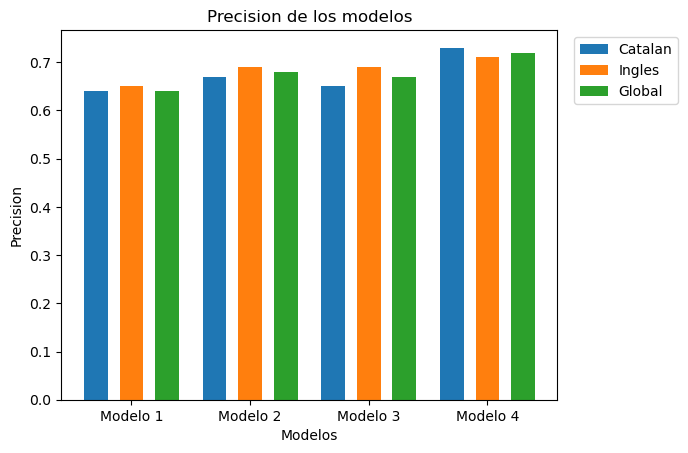

In [112]:
X = ['Modelo 1','Modelo 2','Modelo 3','Modelo 4']
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.3, res_cat, 0.2, label = 'Catalan')
plt.bar(X_axis , res_ing, 0.2, label = 'Ingles')
plt.bar(X_axis+0.3 ,res_glo, 0.2, label = 'Global')
plt.xticks(X_axis, X)
plt.xlabel("Modelos")
plt.ylabel("Precision")
plt.title("Precision de los modelos")
plt.legend(bbox_to_anchor=(1.02, 1),loc="upper left")
plt.show()

Analizando los resultados podemos concluir que utilizar caracteristicas especifica para un conjunto de datos pequeños no es muy buena opcion debido a que es altamente probable que dichas caracteristicas apenas aparezcan en las muestras y por lo tanto no aportarñian mucha información al modelo, consiguiendo peores resultados.